Dataset : https://www.kaggle.com/datasets/mfaisalqureshi/spam-email

Import Data

In [153]:
import pandas as pd
df = pd.read_csv('/content/spam.csv')

In [154]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Ambil Label

In [155]:
category = pd.get_dummies(df['Category'])

Gabungkan data yang telah diproses

In [156]:
df_baru = pd.concat([df, category], axis=1)

Buang kolom Category yang lama

In [157]:
df_baru = df_baru.drop(columns='Category')

In [158]:
df_baru.head()

,Message,ham,spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0


Ambil Data

In [159]:
email = df_baru['Message'].values
label = df_baru[['ham', 'spam']]

Bagi data menjadi train dan test

In [161]:
from sklearn.model_selection import train_test_split
email_train, email_test, label_train, label_test = train_test_split(email, label, test_size=0.2)

Tokenisasi Kata

In [162]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [163]:
tokenizer = Tokenizer(num_words=250, oov_token='-')

tokenizer.fit_on_texts(email_train)
tokenizer.fit_on_texts(email_test)

sekuens_train = tokenizer.texts_to_sequences(email_train)
sekuens_test = tokenizer.texts_to_sequences(email_test)

padded_train = pad_sequences(sekuens_train, maxlen=30)
padded_test = pad_sequences(sekuens_test, maxlen=30)

Model

In [164]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=250, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [168]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, None, 64)          16000     
                                                                 
 lstm_28 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 256)               16640     
                                                                 
 dropout_73 (Dropout)        (None, 256)               0         
                                                                 
 dense_114 (Dense)           (None, 128)               32896     
                                                                 
 dropout_74 (Dropout)        (None, 128)             

In [172]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Implementasi Callback

In [173]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

Callback learning scheduler, yang mana jika epoch sudah diatas 10, maka learning rate akan dikurangi

In [174]:
my_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Proses training model

In [175]:
num_epochs = 15
history = model.fit(padded_train, label_train, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2,
                    callbacks=[my_callback])

Epoch 1/15
140/140 - 10s - loss: 0.2443 - accuracy: 0.8988 - val_loss: 0.0835 - val_accuracy: 0.9776 - lr: 0.0010 - 10s/epoch - 70ms/step
Epoch 2/15
140/140 - 7s - loss: 0.0818 - accuracy: 0.9767 - val_loss: 0.0712 - val_accuracy: 0.9821 - lr: 0.0010 - 7s/epoch - 48ms/step
Epoch 3/15
140/140 - 5s - loss: 0.0614 - accuracy: 0.9823 - val_loss: 0.0630 - val_accuracy: 0.9821 - lr: 0.0010 - 5s/epoch - 33ms/step
Epoch 4/15
140/140 - 3s - loss: 0.0521 - accuracy: 0.9850 - val_loss: 0.0776 - val_accuracy: 0.9803 - lr: 0.0010 - 3s/epoch - 22ms/step
Epoch 5/15
140/140 - 4s - loss: 0.0515 - accuracy: 0.9863 - val_loss: 0.0792 - val_accuracy: 0.9812 - lr: 0.0010 - 4s/epoch - 26ms/step
Epoch 6/15
140/140 - 4s - loss: 0.0487 - accuracy: 0.9863 - val_loss: 0.0573 - val_accuracy: 0.9857 - lr: 0.0010 - 4s/epoch - 29ms/step
Epoch 7/15
140/140 - 4s - loss: 0.0418 - accuracy: 0.9883 - val_loss: 0.0619 - val_accuracy: 0.9830 - lr: 0.0010 - 4s/epoch - 31ms/step
Epoch 8/15
140/140 - 4s - loss: 0.0360 - accur

In [177]:
import matplotlib.pyplot as plt

Plot Loss

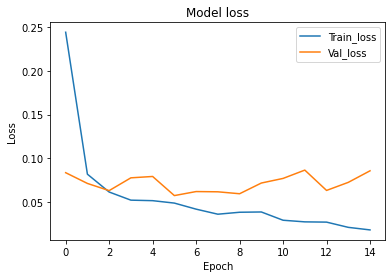

In [178]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_loss', 'Val_loss'], loc='upper right')
plt.show()

Plot Akurasi

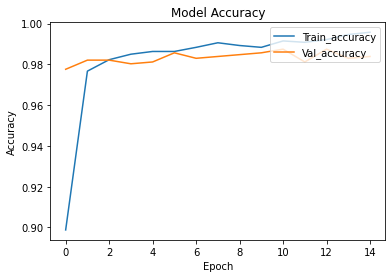

In [180]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper right')
plt.show()